# Projeto: Credit Score Model

## Bibliotecas

In [51]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import inflection
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp
import joblib
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

import missingno as msno  
from boruta import BorutaPy
from imblearn.pipeline import make_pipeline

from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb
import shap
pd.set_option('display.max_columns', None)

import jupyterthemes as jt 
from jupyterthemes import jtplot  
jtplot.style(theme='monokai')

### Funções Auxiliares

In [52]:
def distribuicao_2(dataframe, variavel, same_scale = True):
    data_wide = dataframe.pivot(columns='target',
                         values=variavel)
    if same_scale == False:
        data_wide[0] = np.log(1 + data_wide[0])
        data_wide[1] = np.log(1 + data_wide[1])
    else:
        pass
        
    data_wide.plot.density(figsize = (15, 7),
                           linewidth = 2)
    if same_scale == False:
        plt.xlabel(variavel+' (em escala logaritimca)')
    else:
        plt.xlabel(variavel)
    lista1 = dataframe.groupby('target')[variavel].describe().round(2).values.tolist()
    lista2 = [list(dataframe.groupby('target')[variavel].describe().round(2).transpose().index)]
    lista3 = [['Não Target', 'Target']] + lista2 + lista1

    #statistics = print(dataframe.groupby('target')[variavel].describe().round(2).transpose().to_string(justify='right'))
    plt.figtext(0.73,0.73, '  '.join(map(str,lista3[0])), {'multialignment':'right'}, fontsize = 12)
    plt.figtext(0.729,0.73, '___________________', {'multialignment':'right'}, fontsize = 12)
    plt.figtext(0.67,0.48, '\n'.join(map(str, lista3[1])), {'multialignment':'left'}, fontsize = 12)
    plt.figtext(0.75,0.48, '\n'.join(map(str,lista3[2])) , {'multialignment':'right'}, fontsize = 12)
    plt.figtext(0.83,0.48, '\n'.join(map(str,lista3[3])) , {'multialignment':'right'}, fontsize = 12)
    plt.show()

#### Funções Pipe

In [53]:
def remover_colunas_com_nulos(df, limite_porcentagem_nulos=30):
    """
    Remove colunas com mais de 30% de valores nulos
    """
    porcentagem_nulos = (df.isnull().sum() / len(df)) * 100
    colunas_a_remover = porcentagem_nulos[porcentagem_nulos > limite_porcentagem_nulos].index.tolist()
    df = df.drop(columns=colunas_a_remover)
    return df

def calcular_porcentagem_de_nulos(df):
    """
    Calcula a porcentagem de valores nulos
    """
    perc_nulos = (df.isnull().sum() / len(df)) * 100
    perc_nulos_df = pd.DataFrame({'Coluna': perc_nulos.index, '% de Nulos': perc_nulos.values})
    perc_nulos_df = perc_nulos_df.sort_values(by='% de Nulos', ascending=False)
    return perc_nulos_df

def imputar_valores_nulos(df, colunas, estrategias):    
    for coluna, estrategia in zip(colunas, estrategias):
        if estrategia == 'media':
            imputer = SimpleImputer(strategy='mean')
        elif estrategia == 'moda':
            imputer = SimpleImputer(strategy='most_frequent')
        
        df[coluna] = imputer.fit_transform(df[[coluna]])
        
        
def preencher_nulos_com_outro(df, colunas_a_preencher):
    """
    Preenche os valores nulos com 'Outro'
    """
    for coluna in colunas_a_preencher:
        df[coluna].fillna('Outro', inplace=True)

def imputar_valores_nulos_geral(df):    
    for coluna in df.columns:
        if df[coluna].dtype == 'object':  
            imputer = SimpleImputer(strategy='most_frequent')
        else:
            imputer = SimpleImputer(strategy='mean')
        
        if df[coluna].isnull().any():
            df[coluna] = imputer.fit_transform(df[[coluna]])
            
            
def remove_outliers_iqr(df, threshold=1.5):
    """
    Remove outliers de um DataFrame com base no método IQR (Interquartile Range)

    """
    # Identificar colunas numéricas (excluindo 'ID' e 'IDADE')
    features_numericas = df.select_dtypes(include=['int64', 'float64']).columns.difference(['ID', 'IDADE','TARGET'])

    # Criar uma cópia do DataFrame para preservar o original
    df_no_outliers = df.copy()

    # Remover outliers nas colunas numéricas
    for feature in features_numericas:
        Q1 = df_no_outliers[feature].quantile(0.25)
        Q3 = df_no_outliers[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        df_no_outliers = df_no_outliers[(df_no_outliers[feature] >= lower_bound) & (df_no_outliers[feature] <= upper_bound)]

    return df_no_outliers


### Carregando os Dados

In [54]:
data = pd.read_csv('data_base/train.csv')
data_teste = pd.read_csv('data_base/test.csv')

## Descrição dos Dados

In [55]:
print("O conjunto de dado de treinamet total tem a dimensão {}". format(data.shape))
print("O conjunto de dado de teste total tem a dimensão {}". format(data_teste.shape))

O conjunto de dado de treinamet total tem a dimensão (144469, 151)
O conjunto de dado de teste total tem a dimensão (71157, 151)


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144469 entries, 0 to 144468
Columns: 151 entries, REF_DATE to ID
dtypes: float64(34), int64(3), object(114)
memory usage: 166.4+ MB


In [57]:
data.head(2)

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,VAR17,VAR18,VAR19,VAR20,VAR21,VAR22,VAR23,VAR24,VAR25,VAR26,VAR27,VAR28,VAR29,VAR30,VAR31,VAR32,VAR33,VAR34,VAR35,VAR36,VAR37,VAR38,VAR39,VAR40,VAR41,VAR42,VAR43,VAR44,VAR45,VAR46,VAR47,VAR48,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,ID
0,2017-01-25 00:00:00+00:00,1,F,24.471,NaN,SP,-23.549841,-46.959865,E,E,ALTA,0.0,0.095,NaN,0.222,0.192,0.083333,NaN,0.983562,2.2,NaN,NaN,0.125,NaN,0.017,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.378548,0.451697,0.438720,0.499008,NaN,NaN,NaN,NaN,1.0,NaN,S,N,N,N,N,S,N,N,N,N,N,S,S,N,N,N,N,MEDIA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,ALTA,ALTA,ALTA,MEDIA,ALTA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,ALTA,ALTA,ALTA,ALTA,MEDIA,MEDIA,MEDIA,ALTA,BAIXISSIMA,MEDIA,MEDIA,ALTA,ALTA,ALTA,MEDIA,ALTA,ALTA,MEDIA,ALTISSIMA,MEDIA,LONGE,MEDIO,LONGE,LONGE,LONGE,MEDIO,LONGE,PROXIMO,MEDIO,MEDIO,LONGE,MEDIO,MEDIO,LONGE,LONGE,MEDIO,MEDIO,LONGE,MUITO LONGE,MEDIO,LONGE,LONGE,LONGE,MEDIO,MEDIO,MEDIO,LONGE,LONGE,MEDIO,LONGE,MEDIO,MEDIO,MEDIO,LONGE,PROXIMO,LONGE,MEDIO,LONGE,MEDIO,1399.037809,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1,280764
1,2017-04-03 00:00:00+00:00,1,F,35.041,NaN,BA,-12.924251,-38.487840,E,E,ALTA,0.0,0.005,NaN,0.120,NaN,0.166667,NaN,1.101370,NaN,NaN,NaN,NaN,NaN,0.017,NaN,NaN,NaN,0.0,NaN,0.063,NaN,NaN,NaN,NaN,S,S,198.0,NaN,0.476678,0.401271,0.393429,0.508360,NaN,NaN,NaN,NaN,0.0,NaN,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,ALTA,BAIXISSIMA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,MEDIA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,BAIXISSIMA,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,LONGE,LONGE,PROXIMO,MEDIO,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,MEDIO,LONGE,PROXIMO,MEDIO,PROXIMO,LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,PROXIMO,MEDIO,MEDIO,MEDIO,MEDIO,1516.196234,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1,270129


In [58]:
teste_copia = data_teste.copy()

### Regra de Negócio

Estipulamos como regras do negócio:
* Determinar Classe 0 - Bom Pagador como classe Positiva, deixar ela como Classe 1.
* Por regras que seguem os Bancos, referente a atuação em empréstimos, onde a idade limite para empréstimos é de 80 anos, nós colocaremos um corte em 90 anos.
* Variáveis que tenham valores nulos a partir de 30%, serán removidas da análise.


#### Definir TARGET = 0 como Classe Positiva (Agora será Classe 1)

In [59]:
data['TARGET'] = data['TARGET'].apply(lambda x: 0 if x == 1 else 1)
data_teste['TARGET'] = data_teste['TARGET'].apply(lambda x: 0 if x == 1 else 1)

#### Variável: Idade

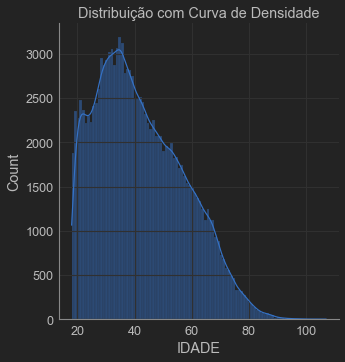

In [60]:
sns.displot(data['IDADE'], kde=True) # "kde=True" adiciona a curva de densidade suavizada
plt.title("Distribuição com Curva de Densidade")
plt.show()

> [!IMPORTANT]
> Por regra de negócio que seguem os bancos, a ideade terá um corte em 90.

In [61]:
data = data.query('IDADE< 91')
data_teste = data_teste.query('IDADE< 91')

In [62]:
print("O conjunto de dado de treinamento tem a dimensão {}". format(data.shape))
print("O conjunto de dado de teste tem a dimensão {}". format(data_teste.shape))

O conjunto de dado de treinamento tem a dimensão (127840, 151)
O conjunto de dado de teste tem a dimensão (63099, 151)


### Dimensão dos Dados

In [63]:
print(data.TARGET.value_counts())
print("\nOs Targets no Treinamento representam {:.2f}% do dataset.\n".format((data[data.TARGET == 1].shape[0] / data.shape[0]) * 100))

0    102761
1     25079
Name: TARGET, dtype: int64

Os Targets no Treinamento representam 19.62% do dataset.



In [64]:
print(data_teste.TARGET.value_counts())
print("\nOs Targets no Teste representam {:.2f}% do dataset.\n".format((data_teste[data_teste.TARGET == 1].shape[0] / data_teste.shape[0]) * 100))

0    50737
1    12362
Name: TARGET, dtype: int64

Os Targets no Teste representam 19.59% do dataset.



### Tipo dos Dados

In [65]:
data['REF_DATE'] = pd.to_datetime(data['REF_DATE'])
data_teste['REF_DATE'] = pd.to_datetime(data_teste['REF_DATE'])
data.dtypes

REF_DATE    datetime64[ns, UTC]
TARGET                    int64
VAR2                     object
IDADE                   float64
VAR4                     object
                   ...         
VAR146                  float64
VAR147                    int64
VAR148                   object
VAR149                   object
ID                        int64
Length: 151, dtype: object

### Dados Ausentes

In [66]:
df = data.copy()
dftes = data_teste.copy()

In [67]:
df_info = calcular_porcentagem_de_nulos(df)
df_info

,Coluna,% de Nulos
146,VAR146,99.852941
4,VAR4,99.801314
46,VAR46,99.723874
45,VAR45,99.723874
44,VAR44,99.647997
...,...,...
1,TARGET,0.000000
47,VAR47,0.000000
39,VAR39,0.000000
3,IDADE,0.000000


#### Aplicando 2da Regra de Negócio ( nulos < 30%)

In [68]:
df = remover_colunas_com_nulos(df)
dftes = remover_colunas_com_nulos(dftes)

In [69]:
print(df.shape)
print(dftes.shape)
print("A base de Treinamento agora tem a dimensão".format(df.shape))
print("\nA base de Teste agora tem a dimensão".format(dftes.shape))

(127840, 115)
(63099, 115)
A base de Treinamento agora tem a dimensão

A base de Teste agora tem a dimensão


In [70]:
df_info1 = calcular_porcentagem_de_nulos(df)
df_info1

,Coluna,% de Nulos
10,VAR18,15.745463
9,VAR14,15.745463
11,VAR24,13.897841
4,VAR5,2.000939
5,VAR6,2.000939
...,...,...
1,TARGET,0.000000
16,VAR47,0.000000
12,VAR39,0.000000
3,IDADE,0.000000


#### Remoção de Outliers

In [75]:
# FIz para VAR14, VAR24, VAR39, VAR40, VAR42 outliers desafiadores
coluna = 'VAR42'
k = 1.5  # Fator para definir os limites dos outliers
# Calcule Q1 e Q3
Q1 = df[coluna].quantile(0.25)
Q3 = df[coluna].quantile(0.75)
# Calcule os limites superior e inferior
LI = Q1 - k * (Q3 - Q1)
LS = Q3 + k * (Q3 - Q1)
# Identifique os outliers
outliers = df[(df[coluna] < LI) | (df[coluna] > LS)]
# Substitua os outliers pelo valor máximo da coluna que não seja outlier
max_sem_outlier = df[(df[coluna] >= LI) & (df[coluna] <= LS)][coluna].max()
df.loc[outliers.index, coluna] = max_sem_outlier

In [80]:
# FIz para VAR14, VAR24, VAR39, VAR40, VAR42 outliers desafiadores
coluna = 'VAR42'
k = 1.5  # Fator para definir os limites dos outliers
# Calcule Q1 e Q3
Q1 = dftes[coluna].quantile(0.25)
Q3 = dftes[coluna].quantile(0.75)
# Calcule os limites superior e inferior
LI = Q1 - k * (Q3 - Q1)
LS = Q3 + k * (Q3 - Q1)
# Identifique os outliers
outliers = dftes[(dftes[coluna] < LI) | (dftes[coluna] > LS)]
# Substitua os outliers pelo valor máximo da coluna que não seja outlier
max_sem_outlier = dftes[(dftes[coluna] >= LI) & (dftes[coluna] <= LS)][coluna].max()
dftes.loc[outliers.index, coluna] = max_sem_outlier

In [81]:
# Agora tiramos os outliers geral de todo o conjunto de dados
df_sem_outliers = remove_outliers_iqr(df)
df_sem_outliers1 = remove_outliers_iqr(dftes) 

### Preenchendo valores vazios

In [82]:
df_info3 = calcular_porcentagem_de_nulos(df)
df_info3

,Coluna,% de Nulos
10,VAR18,15.745463
9,VAR14,15.745463
11,VAR24,13.897841
4,VAR5,2.000939
5,VAR6,2.000939
...,...,...
1,TARGET,0.000000
16,VAR47,0.000000
12,VAR39,0.000000
3,IDADE,0.000000


#### Imputações com Media e Moda

Se os dados são numéricos imputaremos com a Média.<br>
Se os dados são categóricos imputaremos com a Moda.

In [83]:
colunas_a_preencher = ['VAR2', 'VAR49', 'VAR50', 'VAR51', 'VAR52', 'VAR53', 'VAR54', 'VAR55', 'VAR56', 'VAR57', 'VAR58', 'VAR59', 'VAR60', 'VAR61', 'VAR62', 'VAR63', 'VAR64', 'VAR65', 'VAR5']
preencher_nulos_com_outro(df, colunas_a_preencher)
preencher_nulos_com_outro(dftes, colunas_a_preencher)

imputar_valores_nulos(df, colunas=['IDADE','VAR40','VAR9','VAR10','VAR14','VAR6','VAR7', 'VAR14', 'VAR18', 'VAR24', 'VAR39', 'VAR140', 'VAR84', 'VAR85', 'VAR87', 'VAR142', 'VAR114', 'VAR109', 'VAR115', 'VAR134', 'VAR135', 'VAR82', 'VAR86', 'VAR88', 'VAR42'], 
                      estrategias=['media','moda','moda','moda','media','moda','moda', 'media', 'media', 'media', 'media', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda','media'])
imputar_valores_nulos(dftes, colunas=['IDADE','VAR40','VAR9','VAR10','VAR14','VAR6','VAR7', 'VAR14', 'VAR18', 'VAR24', 'VAR39', 'VAR140', 'VAR84', 'VAR85', 'VAR87', 'VAR142', 'VAR114', 'VAR109', 'VAR115', 'VAR134', 'VAR135', 'VAR82', 'VAR86', 'VAR88', 'VAR42'], 
                      estrategias=['media','moda','moda','moda','media','moda','moda', 'media', 'media', 'media', 'media', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda','media'])

imputar_valores_nulos_geral(df)
imputar_valores_nulos_geral(dftes)

df_info2 = calcular_porcentagem_de_nulos(df)
df_info4 = calcular_porcentagem_de_nulos(dftes)

In [84]:
## Verificação final 
df_info2

,Coluna,% de Nulos
0,REF_DATE,0.0
86,VAR118,0.0
84,VAR116,0.0
83,VAR115,0.0
82,VAR114,0.0
...,...,...
34,VAR66,0.0
33,VAR65,0.0
32,VAR64,0.0
31,VAR63,0.0


In [85]:
df.head(2)

,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR9,VAR10,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,VAR149,ID
0,2017-01-25 00:00:00+00:00,0,F,24.471,SP,-23.549841,-46.959865,E,ALTA,0.222,0.983562,0.017,0.378548,0.451697,0.438720,0.499008,1.0,S,N,N,N,N,S,N,N,N,N,N,S,S,N,N,N,N,MEDIA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,ALTA,ALTA,ALTA,MEDIA,ALTA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,ALTA,ALTA,ALTA,ALTA,MEDIA,MEDIA,MEDIA,ALTA,BAIXISSIMA,MEDIA,MEDIA,ALTA,ALTA,ALTA,MEDIA,ALTA,ALTA,MEDIA,ALTISSIMA,MEDIA,LONGE,MEDIO,LONGE,LONGE,LONGE,MEDIO,LONGE,PROXIMO,MEDIO,MEDIO,LONGE,MEDIO,MEDIO,LONGE,LONGE,MEDIO,MEDIO,LONGE,MUITO LONGE,MEDIO,LONGE,LONGE,LONGE,MEDIO,MEDIO,MEDIO,LONGE,LONGE,MEDIO,LONGE,MEDIO,MEDIO,MEDIO,LONGE,PROXIMO,LONGE,MEDIO,LONGE,MEDIO,1399.037809,E,102,EMAIL INEXISTENTE,2.6.1,280764
1,2017-04-03 00:00:00+00:00,0,F,35.041,BA,-12.924251,-38.487840,E,ALTA,0.120,1.101370,0.017,0.476678,0.401271,0.393429,0.508360,0.0,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,ALTA,BAIXISSIMA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,MEDIA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,BAIXISSIMA,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,LONGE,LONGE,PROXIMO,MEDIO,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,MEDIO,LONGE,PROXIMO,MEDIO,PROXIMO,LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,PROXIMO,MEDIO,MEDIO,MEDIO,MEDIO,1516.196234,E,102,EMAIL INEXISTENTE,2.6.1,270129


In [86]:
print("\nA base de Treinamento agora tem a dimensão {}". format(df.shape))


A base de Treinamento agora tem a dimensão (127840, 115)


### Remoção de Features Constantes

In [87]:
colunas_constantes = [coluna for coluna in df.columns if df[coluna].nunique() == 1]
df = df.drop(columns=colunas_constantes)

In [88]:
colunas_constantes = [coluna for coluna in dftes.columns if dftes[coluna].nunique() == 1]
dftes = dftes.drop(columns=colunas_constantes)

### Matríz de dados faltante

A Matríz verifica visualmente que resolvimos a situação de dados faltantes ou vazíos.

<AxesSubplot:>

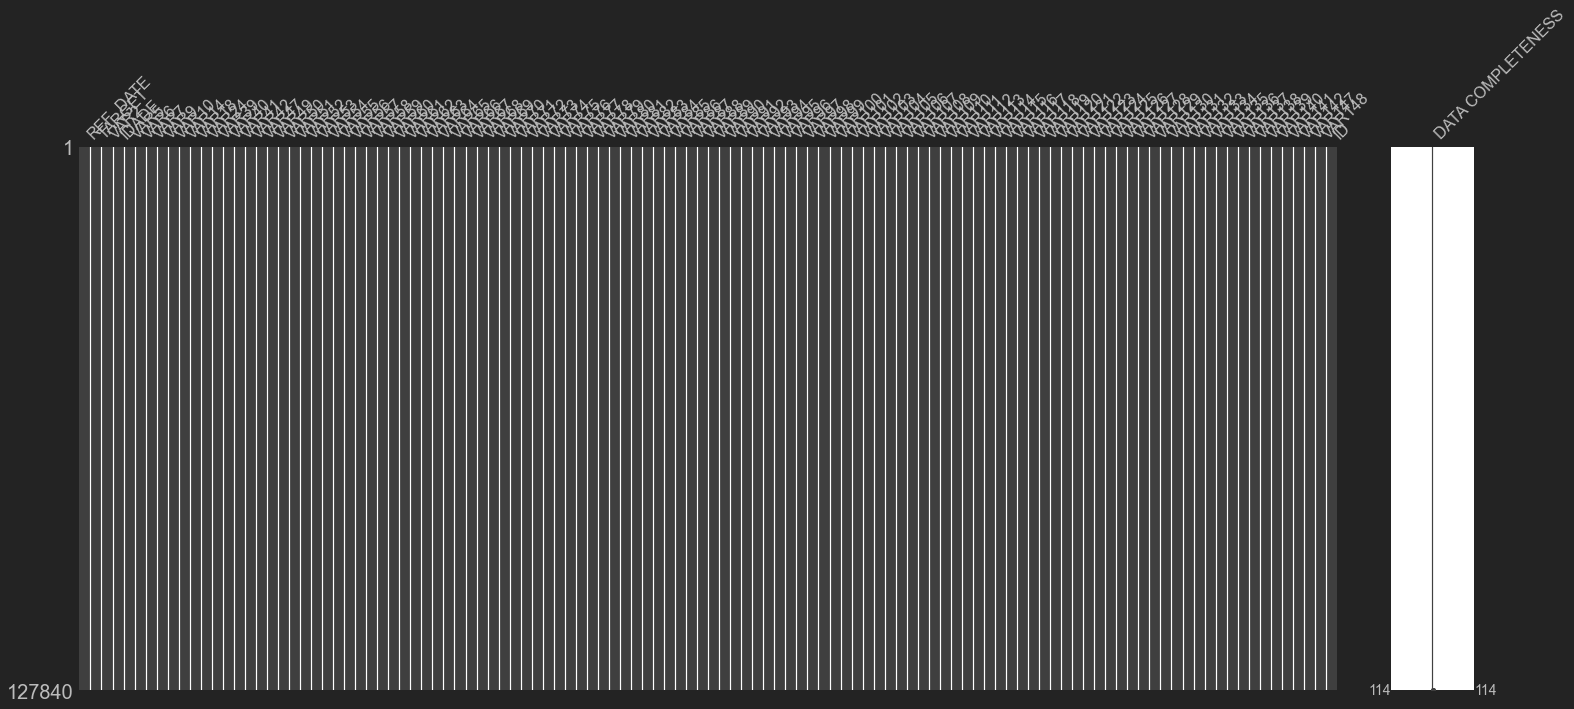

In [71]:
msno.matrix(df, labels=True)  

## Descrição Estatística

In [89]:
num_attributes = df.select_dtypes(include=['int64','float64','int32'])
cat_attributes = df.select_dtypes(exclude=['int64','float64','datetime64[ns]','int32'])

#### Atributos numéricos

In [73]:
# Tendencia Central - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersión - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x:x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

In [76]:
m = pd.concat([d2,d3,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=['Attributes','Min','Max','Mean','Median','std','skew','kurtosis']
m

,Attributes,Min,Max,Mean,Median,std,skew,kurtosis
0,TARGET,0.000000,1.000000,0.196175,0.000000,0.397102,1.530228,0.341604
1,IDADE,18.014000,90.948000,42.097349,39.819000,15.170383,0.479196,-0.552009
2,VAR6,-33.521563,4.478585,-14.935325,-14.865949,9.107631,-0.001635,-1.331609
3,VAR7,-72.900276,-32.429516,-46.076253,-46.702500,7.462701,-0.613500,0.404536
4,VAR14,0.029000,0.232000,0.133909,0.133909,0.035978,0.618863,1.244596
5,VAR18,0.002740,2.471023,0.986690,0.986690,0.457153,-0.135280,-0.880559
6,VAR24,0.000000,0.207000,0.060357,0.052000,0.063414,1.138065,0.296813
7,VAR39,0.103713,0.844576,0.474666,0.471264,0.136587,-0.044975,-0.462155
8,VAR40,0.249189,0.784665,0.534098,0.511767,0.113424,0.776212,-0.125740
9,VAR41,0.000000,1.000000,0.629786,0.545414,0.219511,0.373755,-1.384044


Pontos Importantes:<br>
1. A media da variável IDADE é de 42 aprox. não distando demais das medias das classes quando separadas.
2. A variável VAR141 chega a um máximo de 46 mil aprox, sendo uma média de 2 mil aprox; o que reforça a ideia que seja a representação de uma variável monetária.
3. As outras variáveis não conseguem entregar uma noção do que são por estarem bem encapsuladas.

## Engenharia de Features

Trabalharei a variável REF_DATA, obtendo o dia e a semana em questão.

In [90]:
df['DIA'] = df['REF_DATE'].dt.day
df['SEM'] = df['REF_DATE'].dt.week
dftes['DIA'] = dftes['REF_DATE'].dt.day
dftes['SEM'] = dftes['REF_DATE'].dt.week

#### Transformação por Natureza

Transformação por natureza é uma técnica que tenta capturar o comportamento cíclico da variável, caso ela tenha, é baseado na função de sino e cosino

In [91]:
# Dia
df['DIA_SIN'] = df['DIA'].apply(lambda x: np.sin(x *(2. * np.pi/30)))
df['DIA_COS'] = df['DIA'].apply(lambda x: np.cos(x *(2. * np.pi/30)))
# Semana
df['SEM_SIN'] = df['SEM'].apply(lambda x: np.sin(x *(2. * np.pi/7)))
df['SEM_COS'] = df['SEM'].apply(lambda x: np.cos(x *(2. * np.pi/7)))
# Dia
dftes['DIA_SIN'] = dftes['DIA'].apply(lambda x: np.sin(x *(2. * np.pi/30)))
dftes['DIA_COS'] = dftes['DIA'].apply(lambda x: np.cos(x *(2. * np.pi/30)))
# Semana
dftes['SEM_SIN'] = dftes['SEM'].apply(lambda x: np.sin(x *(2. * np.pi/7)))
dftes['SEM_COS'] = dftes['SEM'].apply(lambda x: np.cos(x *(2. * np.pi/7)))

Guardo os dados de Teste antes de aplicar as transformaçoes nele.

In [92]:
copia_df_testes_1 = dftes.copy()

## Transformação dos Dados

### Aplicando Encoders

Nota: Aplicamos LabelEncoder para converter variável cat em num.

In [93]:
col_le = ['VAR2', 'VAR5', 'VAR9', 'VAR10','VAR49','VAR50','VAR51','VAR52',
          'VAR53', 'VAR54','VAR55','VAR56','VAR57','VAR58','VAR59','VAR60',
          'VAR61','VAR62', 'VAR63','VAR64','VAR65','VAR142', 'VAR148']
lbl = LabelEncoder()

for coluna in col_le:
    df[coluna] = lbl.fit_transform(df[coluna])

for coluna in col_le:
    dftes[coluna] = lbl.fit_transform(dftes[coluna])    

Nota: Aplicamos OrdinalEncoders para variáveis com as que SIM nos importamos no ordem.

In [94]:
col_oe = ['VAR66', 'VAR67', 'VAR68', 'VAR69','VAR70','VAR71','VAR72','VAR73','VAR74','VAR75',
          'VAR76', 'VAR77', 'VAR78', 'VAR79','VAR80','VAR81','VAR82','VAR83','VAR84','VAR85',
          'VAR86', 'VAR87', 'VAR88', 'VAR89','VAR90','VAR91','VAR92','VAR93','VAR94','VAR95',
          'VAR96', 'VAR97', 'VAR98', 'VAR99','VAR100','VAR101','VAR102','VAR103','VAR104','VAR105',
          'VAR106', 'VAR107', 'VAR108', 'VAR109','VAR110','VAR111','VAR112','VAR113','VAR114','VAR115',
          'VAR116', 'VAR117', 'VAR118', 'VAR119','VAR120','VAR121','VAR122','VAR123','VAR124','VAR125',
          'VAR126', 'VAR127', 'VAR128', 'VAR129','VAR130','VAR131','VAR132','VAR133','VAR134','VAR135',
          'VAR136', 'VAR137', 'VAR138', 'VAR139','VAR140','VAR111','VAR112','VAR113','VAR114','VAR115',
          ]
ord = OrdinalEncoder()
for coluna in col_oe:
    df[coluna] = ord.fit_transform(df[coluna].values.reshape(-1, 1))    
for coluna in col_oe:
    dftes[coluna] = ord.fit_transform(dftes[coluna].values.reshape(-1, 1))

In [95]:
df.head(2)

,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR9,VAR10,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,ID,DIA,SEM,DIA_SIN,DIA_COS,SEM_SIN,SEM_COS
0,2017-01-25 00:00:00+00:00,0,0,24.471,26,-23.549841,-46.959865,4,0,0.222,0.983562,0.017,0.378548,0.451697,0.438720,0.499008,1.0,2,0,0,0,0,2,0,0,0,0,0,2,2,0,0,0,0,3.0,0.0,3.0,0.0,3.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,0.0,1.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,4.0,0.0,1.0,0.0,1.0,1399.037809,4,102,2,280764,25,4,-0.866025,0.500000,-4.338837e-01,-0.900969
1,2017-04-03 00:00:00+00:00,0,0,35.041,4,-12.924251,-38.487840,4,0,0.120,1.101370,0.017,0.476678,0.401271,0.393429,0.508360,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,4.0,1.0,4.0,1.0,1.0,1.0,4.0,1.0,4.0,3.0,4.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,4.0,1.0,4.0,0.0,4.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,1.0,1516.196234,4,102,2,270129,3,14,0.587785,0.809017,-4.898587e-16,1.000000


#### Gráfico de Correlação

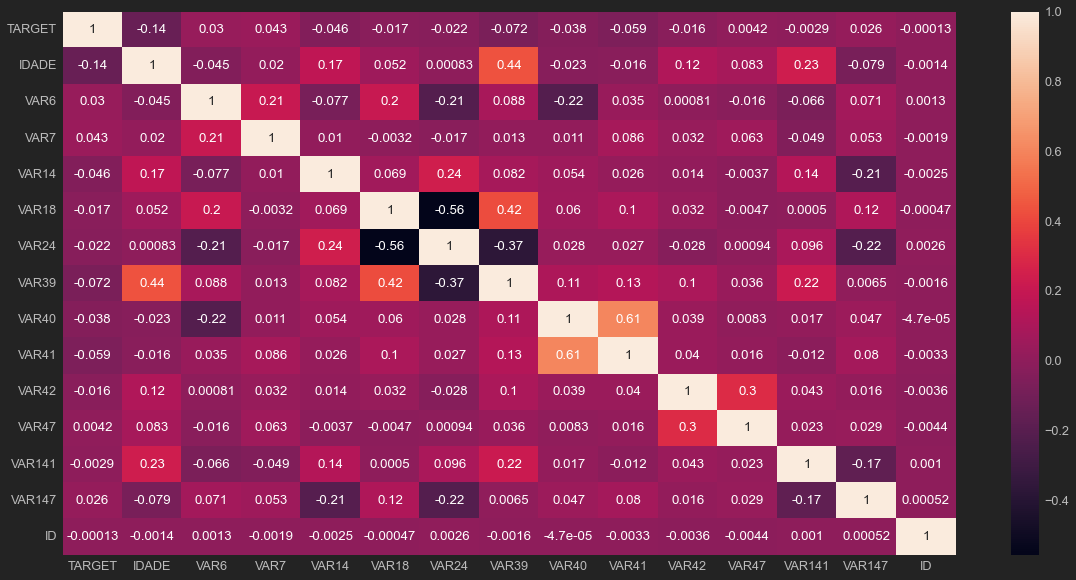

In [86]:
fig = plt.figure(figsize =(20, 10))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True);

Mostramos a correlação de variáveis numéricas que tinhas separados para as estatísticas. Percebemos correlações fracas.

### Normalização dos Dados

#### Aplicando Rescaling

Nota: 
* Aplicaremos RobustScaler para dados sensíveis de outliers. <br>
* Aplicaremos MinMaxScaler para dados de menor escala.

In [96]:
robust = RobustScaler()
col_rs = ['IDADE', 'VAR6', 'VAR7','VAR141','VAR39', 'VAR42', 'VAR18', 'VAR14', 
          'VAR40', 'VAR41', 'VAR47', 'VAR24']
drs = df[col_rs]
rs = robust.fit_transform(drs)
df[col_rs] = rs
drs1 = dftes[col_rs]
rs = robust.fit_transform(drs1)
dftes[col_rs] = rs 

In [97]:
minmax = MinMaxScaler()
col_rs = ['VAR14','VAR5', 'VAR147']
mms = df[col_rs]
ms = minmax.fit_transform(mms)
df[col_rs] = ms
mms1 = dftes[col_rs]
ms = minmax.fit_transform(mms1)
dftes[col_rs] = ms 

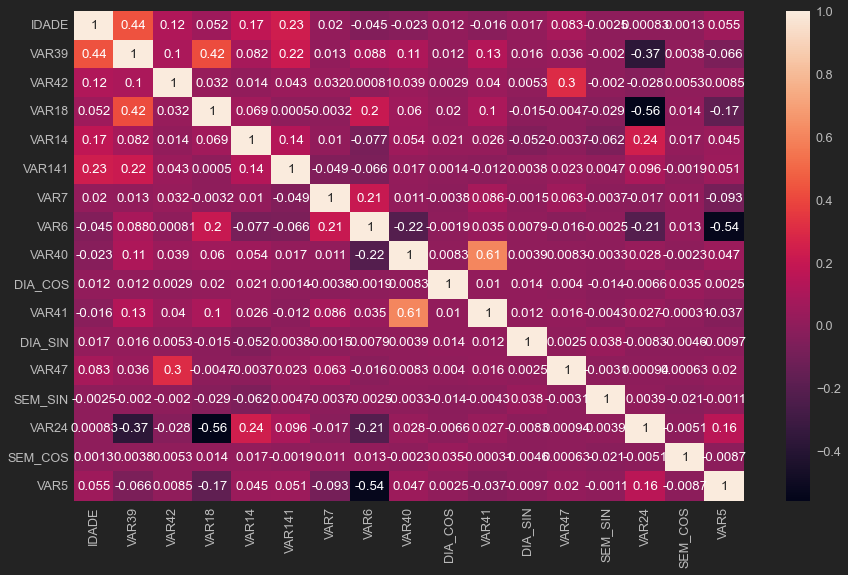

In [89]:
columns_corr= ['IDADE','VAR39','VAR42','VAR18','VAR14','VAR141','VAR7','VAR6','VAR40','DIA_COS',
                'VAR41','DIA_SIN','VAR47','SEM_SIN','VAR24','SEM_COS','VAR5']
df_corr = df[columns_corr].copy() 
fig = plt.figure(figsize =(15, 9))
correlation = df_corr.corr(method='pearson')
sns.heatmap(correlation,annot=True);

Guardamos novamente os dataset, desta vez com tratamento.

In [98]:
df_reserva = df.copy()
df_reservates = dftes.copy()

#### Filtrar Colunas

In [99]:
col_rem = ['REF_DATE','DIA', 'SEM','ID']
df = df.drop(col_rem, axis=1)
dftes = dftes.drop(col_rem, axis=1)

In [333]:
df.head(2)

,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR9,VAR10,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,ID,DIA_SIN,DIA_COS,SEM_SIN,SEM_COS
0,0,0,-0.667246,0.962963,-0.532226,-0.022855,4,0,0.950739,-0.003682,-0.507246,-0.499950,-0.431685,-0.238652,0.045651,1.346467,2,0,0,0,0,2,0,0,0,0,0,2,2,0,0,0,0,3.0,0.0,3.0,0.0,3.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,0.0,1.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,4.0,0.0,1.0,0.0,1.0,-0.841441,4,1.0,2,280764,-0.866025,0.500000,-4.338837e-01,-0.900969
1,0,0,-0.207721,0.148148,0.119004,0.729488,4,0,0.448276,0.134993,-0.507246,0.029194,-0.794064,-0.339958,0.203073,-0.012228,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,4.0,1.0,4.0,1.0,1.0,1.0,4.0,1.0,4.0,3.0,4.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,4.0,1.0,4.0,0.0,4.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,1.0,-0.500343,4,1.0,2,270129,0.587785,0.809017,-4.898587e-16,1.000000


## Seleção de Variáveis

In [100]:
dfx = df.copy()
dfx_tes = dftes.copy()

In [335]:
dfx.head(2)

,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR9,VAR10,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,ID,DIA_SIN,DIA_COS,SEM_SIN,SEM_COS
0,0,0,-0.667246,0.962963,-0.532226,-0.022855,4,0,0.950739,-0.003682,-0.507246,-0.499950,-0.431685,-0.238652,0.045651,1.346467,2,0,0,0,0,2,0,0,0,0,0,2,2,0,0,0,0,3.0,0.0,3.0,0.0,3.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,0.0,1.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,4.0,0.0,1.0,0.0,1.0,-0.841441,4,1.0,2,280764,-0.866025,0.500000,-4.338837e-01,-0.900969
1,0,0,-0.207721,0.148148,0.119004,0.729488,4,0,0.448276,0.134993,-0.507246,0.029194,-0.794064,-0.339958,0.203073,-0.012228,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,4.0,1.0,4.0,1.0,1.0,1.0,4.0,1.0,4.0,3.0,4.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,4.0,1.0,4.0,0.0,4.0,1.0,1.0,1.0,4.0,4.0,1.0,1.0,1.0,1.0,-0.500343,4,1.0,2,270129,0.587785,0.809017,-4.898587e-16,1.000000


### Método: Random Forest Selection

A importancia das variáveis medida pela diminuição na pontuação de impureza Gini ou pela diminuição na métrica de erro médio.

Random forest features importance:


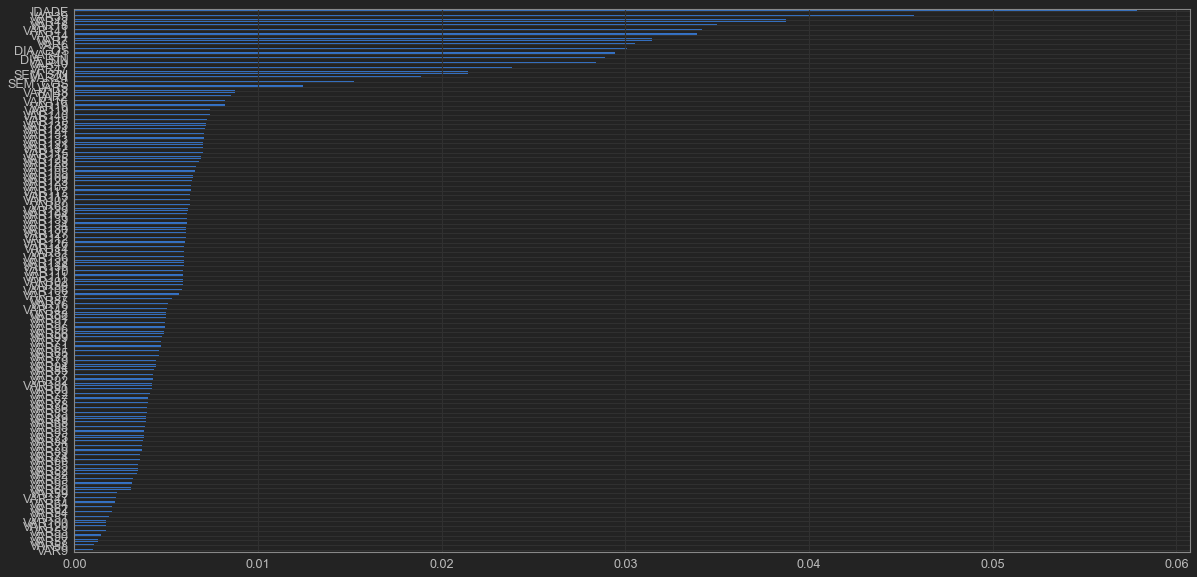

In [95]:
rf_model = RandomForestClassifier(n_jobs= -1)
x_train_rfc = dfx.drop(columns= ['TARGET','ID'])
y_train_rfc = dfx['TARGET']
rf_model.fit(x_train_rfc, y_train_rfc)
plt.figure(figsize= (20, 10))
feat_importances = pd.Series(rf_model.feature_importances_, index= x_train_rfc.columns)
print('Random forest features importance:')
feat_importances.sort_values().plot(kind= 'barh');

Observamos que com essa seleção deste método definimos variáveis com importancia de até 6% aprox.

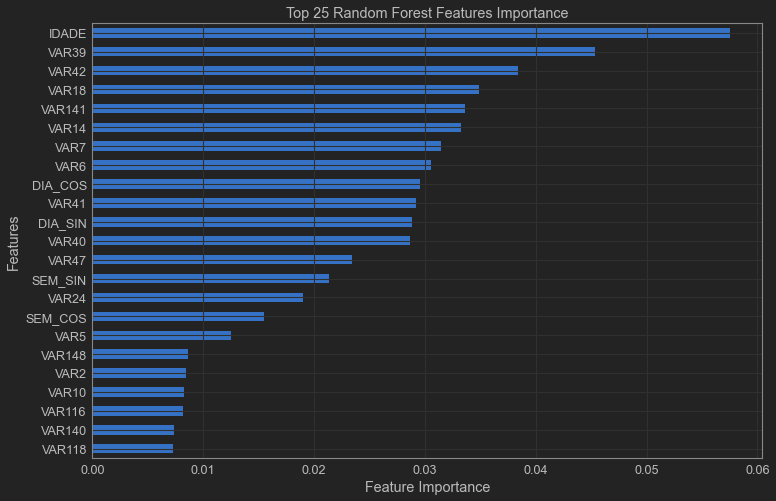

In [101]:
rf_model = RandomForestClassifier(n_jobs=-1)
x_train_rfc = dfx.drop(columns=['TARGET', 'ID'])
y_train_rfc = dfx['TARGET']
rf_model.fit(x_train_rfc, y_train_rfc)
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(rf_model.feature_importances_, index=x_train_rfc.columns)
feat_importances = feat_importances.sort_values(ascending=True)
top_n = 92
feat_importances[top_n:].plot(kind='barh')
plt.title('Top {} Random Forest Features Importance'.format(len(dfx.columns)- top_n))
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show() 

In [103]:
feat_importances.tail(10).sort_values(ascending=False)

IDADE      0.057546
VAR39      0.045369
VAR42      0.038438
VAR18      0.034883
VAR141     0.033630
VAR14      0.033284
VAR7       0.031498
VAR6       0.030562
DIA_COS    0.029603
VAR41      0.029227
dtype: float64

NOTA: A importancia da melhor variável não chega aos 10%. O que reafirma a complexidade dos dados.

### Método: Recursive Feature Elimination (RFE)
RFE funciona eliminando iterativamente as características menos importantes de um conjunto de dados.

In [ ]:
x_train_rfe = dfx.drop(columns= ['TARGET','ID'])
y_train_rfe = dfx['TARGET']
modelorfe = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=modelorfe, n_features_to_select=30)
rfe.fit(x_train_rfe, y_train_rfe)
caracteristicas_selecionadas = x_train_rfe.columns[rfe.support_]
print("Características Selecionadas:")
print(caracteristicas_selecionadas) 

As melhores variáveis fornecidas pelo RFE se asemelham do Selector Random Forest.

In [105]:
cols_rfe=['IDADE', 'VAR5', 'VAR6', 'VAR7', 'VAR14', 'VAR18', 'VAR24', 'VAR39',
       'VAR40', 'VAR41', 'VAR42', 'VAR47', 'VAR115', 'VAR116', 'VAR118',
       'VAR124', 'VAR131', 'VAR132', 'VAR133', 'VAR140', 'VAR141', 'DIA_SIN',
       'DIA_COS', 'SEM_SIN', 'SEM_COS']

### Método: Boruta Selection
Boruta opera por meio de uma abordagem de eliminação gradual de recursos, comparando as características originais com um conjunto de características aleatórias (ruído).

In [228]:
rf_model = RandomForestClassifier(n_jobs = -1)
x_train_boruta = dfx.drop(columns= ['TARGET','ID']).values
y_train_boruta = dfx['TARGET'].values.ravel()
boruta = BorutaPy(rf_model, n_estimators=100, verbose= 2)
boruta.fit(x_train_boruta, y_train_boruta) 

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	111
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	111
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	111
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	111
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	111
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	111
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	111
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	108
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	108
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	108
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	108
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	108
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	108
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	108
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	1
Rejected: 	108
Iteration: 	16 / 100
Confirmed: 	2
Tentative: 	1


BorutaPy(estimator=RandomForestClassifier(n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2474E74B258),
         n_estimators=100, random_state=RandomState(MT19937) at 0x2474E74B258,
         verbose=2)

In [67]:
# instantiating the dataset selected columns by the boruta method
cols = boruta.support_.tolist()
boruta_selected_features = dfx.drop(columns= ['TARGET','ID']).iloc[:, cols].columns.to_list()

print('Boruta selected features:')
boruta_selected_features

Boruta selected features:


['IDADE', 'VAR7', 'VAR39']

O resultado do Boruta acabaram sendo desalentadores também, pela pouca quantidade de features identificadas como relevantes para a modelagem do modelo. Mas as três variáveis consideradas acabam dando um direcionamento para um ponto de partida.

In [108]:
cols_boruta = ['IDADE', 'VAR7', 'VAR39']

## Modelos

### Preparação

In [101]:
seed = 6
np.random.seed(seed) 
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [102]:
columns = ['IDADE','VAR39','VAR18','VAR24','VAR14','VAR141','VAR41','VAR148','VAR123', 'VAR65', 'VAR50' , 
            'DIA_COS','VAR118','VAR7','SEM_SIN','VAR109','SEM_COS','VAR140','VAR69','VAR113',
            'DIA_SIN','VAR6','VAR116','VAR47','VAR2','VAR121','VAR138','VAR108','VAR105','VAR107','VAR104',
            'VAR119','VAR127','VAR117','VAR115','VAR10','VAR128','VAR49','VAR51',
            'VAR142','VAR66','VAR9','VAR5','VAR81','VAR82','VAR79','VAR80',
            'VAR52','VAR53','VAR54','VAR55','VAR56','VAR57','VAR58','VAR59','VAR60',
            'VAR61','VAR62','VAR63','VAR64',
            'VAR67','VAR68','VAR70','VAR71','VAR72','VAR73','VAR74','VAR75','VAR76',
            'VAR77','VAR78','VAR83','VAR84','VAR85','VAR86','VAR87','VAR88','VAR89',
            'VAR90','VAR91','VAR92','VAR93','VAR94','VAR95','VAR96','VAR97','VAR98',
            'VAR99','VAR100','VAR101','VAR102','VAR103','VAR106','VAR110','VAR111','VAR112',
            'VAR114','VAR120','VAR122','VAR124','VAR125','VAR126','VAR129','VAR130',
            'VAR131','VAR132','VAR133','VAR134','VAR135','VAR136','VAR137','VAR139','VAR40',
            'VAR42','VAR147']

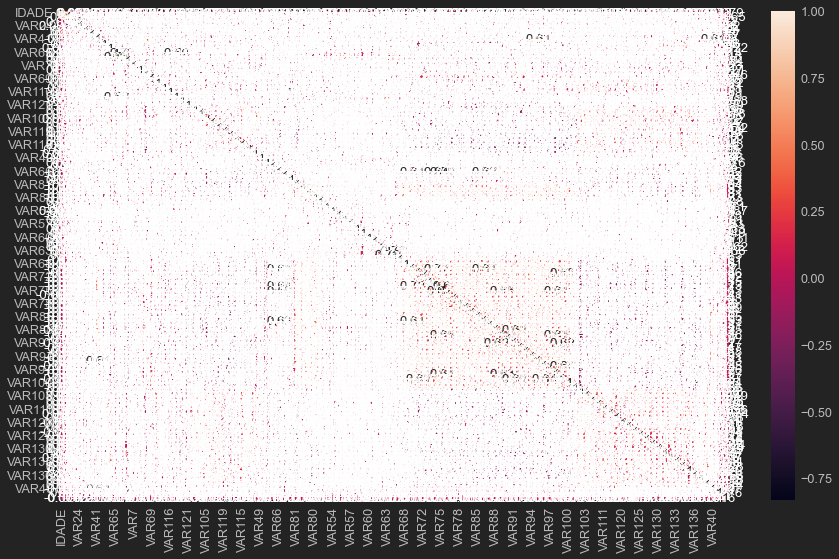

In [236]:
df_corr = df[columns].copy() 
fig = plt.figure(figsize =(15, 9))
correlation = df_corr.corr(method='pearson')
sns.heatmap(correlation,annot=True);

In [338]:
df_corr = df[columns].copy()
correlacoes = df_corr.corr()
tabela_correlacoes = pd.DataFrame(correlacoes)
print(tabela_correlacoes)

           IDADE     VAR39     VAR18     VAR24     VAR14    VAR141     VAR41  \
IDADE   1.000000  0.435502  0.052456  0.000831  0.174463  0.234541 -0.015802   
VAR39   0.435502  1.000000  0.418609 -0.368652  0.082064  0.221090  0.134465   
VAR18   0.052456  0.418609  1.000000 -0.557079  0.068713  0.000498  0.100091   
VAR24   0.000831 -0.368652 -0.557079  1.000000  0.240839  0.095844  0.027300   
VAR14   0.174463  0.082064  0.068713  0.240839  1.000000  0.135937  0.025859   
...          ...       ...       ...       ...       ...       ...       ...   
VAR137  0.044981  0.047132  0.029287 -0.003813  0.026145  0.056428  0.256933   
VAR139  0.037064  0.033663  0.031224 -0.042590  0.002763  0.056145  0.098575   
VAR40  -0.022513  0.106566  0.060114  0.028179  0.053833  0.017320  0.605902   
VAR42   0.119405  0.101160  0.032438 -0.028048  0.014202  0.042652  0.039857   
VAR147 -0.079313  0.006530  0.116042 -0.215769 -0.205484 -0.173061  0.080246   

          VAR148    VAR123     VAR65   

In [266]:
len(columns)

115

### Train Test Split

In [103]:
X_train = dfx[columns]
y_train = df_reserva['TARGET']
X_test = dfx_tes[columns]
y_test = dfx_tes['TARGET']

In [340]:
# Guardando CSV prontos e tratados para eventual uso posterior
X_train.to_csv('data_base/X_train_tratado.csv', index=False)
X_test.to_csv('data_base/X_test_tratado.csv', index=False)
y_train.to_csv('data_base/y_train_tratado.csv', index=False)
y_test.to_csv('data_base/y_test_tratado.csv', index=False)

### Balanceamento dos Dados

In [341]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 25079
Before OverSampling, counts of label '0': 102761 



In [104]:
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

In [ ]:
pipe = make_pipeline(
    SMOTE(),
    RandomForestClassifier()
)
# Defina uma lista de valores de peso para a estratégia de amostragem do SMOTE
weights = np.linspace(0.005, 1, 10)
# Crie um objeto GridSearchCV para ajustar o modelo
gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        'smote__sampling_strategy': weights
    },
    scoring='f1',
    cv=cv
)
# Ajuste o modelo aos dados
grid_result = gsc.fit(X_train, y_train)
# Imprima os melhores parâmetros encontrados
print("Best parameters : %s" % grid_result.best_params_)
# Crie um DataFrame para as pontuações F1
weight_f1_score_df = pd.DataFrame(
    {
        'score': grid_result.cv_results_['mean_test_score'],
        'weight': weights
    }
)
# Plote um gráfico de linha para visualizar as pontuações F1
plt.figure(figsize=(8, 6))
plt.plot(weight_f1_score_df['weight'], weight_f1_score_df['score'], marker='o', linestyle='-')
plt.title('Pontuação F1 vs. Estratégia de Amostragem (SMOTE)')
plt.xlabel('Estratégia de Amostragem (SMOTE)')
plt.ylabel('Pontuação F1')
plt.grid(True)
plt.show() 

In [105]:
ros = SMOTE(random_state=seed, sampling_strategy= 0.63666666666666667) 
X_train_over, y_train_over = ros.fit_resample(X_train, y_train) 

In [106]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))

After OverSampling, counts of label '1': 65424
After OverSampling, counts of label '0': 102761 



### Aplicação de Algoritmos

#### Algoritmo: Linear Discriminant Analysis

In [345]:
X_train_lda = X_train_over
X_test_lda = X_test
y_train_lda = y_train_over
y_test_lda = y_test

In [346]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)  # Especifique o número desejado de componentes
X_lda_train = lda.fit_transform(X_train_lda, y_train_lda)

In [347]:
df_lda_train = pd.DataFrame(data=X_lda_train, columns=['Componente_1'])
df_lda_train['TARGET'] = y_train_lda
print(df_lda_train.head())

   Componente_1  TARGET
0      0.804804       0
1      1.509716       0
2     -0.470790       0
3      0.288101       0
4     -1.386065       0


In [348]:
from sklearn.linear_model import LogisticRegression

model_lda = LogisticRegression()
model_lda.fit(X_lda_train, y_train_lda)

X_lda_test = lda.transform(X_test_lda)
y_pred_lda = model_lda.predict(X_lda_test)

In [349]:
score_lda= accuracy_score(y_test_lda ,y_pred_lda)
precision_lda = precision_score(y_test_lda,y_pred_lda)
recall_lda = recall_score(y_test_lda,y_pred_lda)

In [350]:
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc_lda = roc_auc_score(y_test_lda, y_pred_lda)
print("ROC-AUC Score:", roc_auc_lda)

ROC-AUC Score: 0.5453946325101031


#### Algoritmo: XGBoost 

In [107]:
# Crie uma instância do modelo XGBoost
XGBoost_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary:logistic',  # Use 'binary:logistic' para classificação binária
    random_state=42
)
XGBoost_model.fit(X_train_over, y_train_over)

[00:36:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [108]:
xgb_predic = XGBoost_model.predict(X_test)

score_xg = accuracy_score(y_test ,xgb_predic)
precision_xg = precision_score(y_test,xgb_predic)
recall_xg = recall_score(y_test,xgb_predic)

#### Algoritmo:Decision Tree 

In [ ]:
modelo_arvore = DecisionTreeClassifier()
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 40),
    'min_impurity_decrease': np.arange(0.0, 0.3)
}
n_iter_search = 100 
random_search = RandomizedSearchCV(estimator=modelo_arvore,
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   cv=cv,
                                   scoring='f1')
random_search.fit(X_train_over, y_train_over)

In [ ]:
random_search.best_params_

In [353]:
model_tree = DecisionTreeClassifier(max_depth=40, criterion='gini')
model_tree.fit(X_train_over, y_train_over)

DecisionTreeClassifier(max_depth=40)

In [354]:
tree_predic = model_tree.predict(X_test)

score = accuracy_score(y_test ,tree_predic)
precision = precision_score(y_test,tree_predic)
recall = recall_score(y_test,tree_predic)

#### Algoritmo: Logistic Regression

In [355]:
model_rl = LogisticRegression(
    C=0.1,            
    penalty='l1',     
    solver='liblinear',  
    class_weight='balanced',  
    max_iter=150      
)
model_rl.fit(X_train_over, y_train_over)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=150, penalty='l1',
                   solver='liblinear')

In [356]:
pred = model_rl.predict(X_test)

score1 = accuracy_score(y_test ,pred)
precision1 = precision_score(y_test, pred)
recall1 = recall_score(y_test, pred)

#### Algoritmo: Random Forest 

In [109]:
clf = RandomForestClassifier(n_estimators=150, max_depth=3,
                             class_weight='balanced', random_state=0)

clf.fit(X_train_over, y_train_over)
y_pred_rf = clf.predict(X_test)

score_rf = accuracy_score(y_test ,y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

#### Algoritmo: LightGBM 

In [358]:
import lightgbm as lgb

In [359]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'n_estimators': 100,
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 50,
    'random_state': 42,
    'class_weight': 'balanced'
}

model_lgb = lgb.LGBMClassifier(**params)
model_lgb.fit(X_train_over, y_train_over)

[LightGBM] [Info] Number of positive: 65424, number of negative: 102761
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23790
[LightGBM] [Info] Number of data points in the train set: 168185, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=6,
               metric='binary_logloss', num_leaves=50, objective='binary',
               random_state=42)

In [360]:
y_pred_lgb = model_lgb.predict(X_test)

score_lgb = accuracy_score(y_test ,y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb)
recall_lgb = recall_score(y_test, y_pred_lgb)

#### Performance dos Modelos

Nota: Podemos observar que o modelo se aproxima da aleatoriedade, mas do que da perfeição (igual a 1). AInda temos muito trabalhar no modelo.

In [361]:
results_LR = pd.DataFrame(columns=['Modelo', 'Acurácia','Precision', 'Recall'])
results_LR = results_LR.append({'Modelo': 'Model_LogRegression', 'Acurácia': score1, 'Precision': precision1, 'Recall': recall1, 'AUC-ROC': roc_auc_LR}, ignore_index=True)

results_RF = pd.DataFrame(columns=['Modelo', 'Acurácia','Precision', 'Recall'])
results_RF = results_RF.append({'Modelo': 'Model_RandomForest', 'Acurácia': score_rf, 'Precision': precision_rf, 'Recall': recall_rf, 'AUC-ROC': roc_auc_RF}, ignore_index=True)

results_DT = pd.DataFrame(columns=['Modelo', 'Acurácia','Precision', 'Recall'])
results_DT = results_DT.append({'Modelo': 'Model_DecisionTree', 'Acurácia': score, 'Precision': precision, 'Recall': recall, 'AUC-ROC': roc_auc_DT}, ignore_index=True)

results_XGB = pd.DataFrame(columns=['Modelo', 'Acurácia','Precision', 'Recall'])
results_XGB = results_XGB.append({'Modelo': 'Model_XGBoost', 'Acurácia': score_xg, 'Precision': precision_xg, 'Recall': recall_xg, 'AUC-ROC': roc_auc_XGB}, ignore_index=True)

results_lda = pd.DataFrame(columns=['Modelo', 'Acurácia','Precision', 'Recall'])
results_lda = results_lda.append({'Modelo': 'Model_LDA', 'Acurácia': score_lda, 'Precision': precision_lda, 'Recall': recall_lda, 'AUC-ROC': roc_auc_lda}, ignore_index=True)

results_lgb = pd.DataFrame(columns=['Modelo', 'Acurácia','Precision', 'Recall'])
results_lgb = results_lgb.append({'Modelo': 'Model_LGB', 'Acurácia': score_lgb, 'Precision': precision_lgb, 'Recall': recall_lgb, 'AUC-ROC': roc_auc_lgb}, ignore_index=True)

In [111]:

results_RF = pd.DataFrame(columns=['Modelo', 'Acurácia','Precision', 'Recall'])
results_RF = results_RF.append({'Modelo': 'Model_RandomForest', 'Acurácia': score_rf, 'Precision': precision_rf, 'Recall': recall_rf}, ignore_index=True)
results_XGB = pd.DataFrame(columns=['Modelo', 'Acurácia','Precision', 'Recall'])
results_XGB = results_XGB.append({'Modelo': 'Model_XGBoost', 'Acurácia': score_xg, 'Precision': precision_xg, 'Recall': recall_xg}, ignore_index=True)


In [156]:
combined_results = pd.concat([results_XGB,results_RF, results_LR, results_DT, results_lda], ignore_index=True)
combined_results 

,Modelo,Acurácia,Precision,Recall,AUC-ROC
0,Model_XGBoost,0.780773,0.565716,0.525120,0.627588
1,Model_RandomForest,0.545032,0.246856,0.644718,0.609950
2,Model_LogRegression,0.576475,0.257300,0.615839,0.625061
3,Model_DecisionTree,0.775401,0.257503,0.077738,0.608052
4,Model_LDA,0.801772,0.397472,0.022893,0.507219


In [113]:
combined_results = pd.concat([results_XGB,results_RF], ignore_index=True)
combined_results 

,Modelo,Acurácia,Precision,Recall
0,Model_XGBoost,0.756795,0.291095,0.168177
1,Model_RandomForest,0.551562,0.232597,0.560589


In [362]:
combined_results = pd.concat([results_XGB,results_RF, results_LR, results_DT, results_lgb, results_lda], ignore_index=True)
combined_results = combined_results.sort_values(by='Modelo', ascending=False)
combined_results 

,Modelo,Acurácia,Precision,Recall,AUC-ROC
0,Model_XGBoost,0.756795,0.291095,0.168177,0.581234
1,Model_RandomForest,0.551562,0.232597,0.560589,0.580343
2,Model_LogRegression,0.582814,0.243383,0.535593,0.590188
4,Model_LGB,0.699948,0.266903,0.304320,0.566231
5,Model_LDA,0.710360,0.267019,0.274147,0.545395
3,Model_DecisionTree,0.591499,0.225236,0.444750,0.543038


<Figure size 1080x720 with 0 Axes>

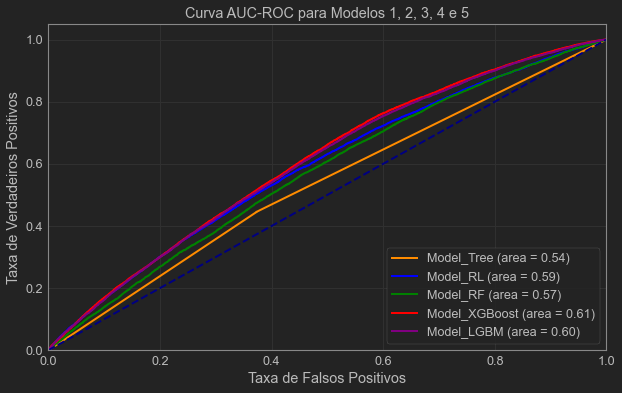

In [363]:
plt.figure(figsize=(15, 10))
# Calcule as probabilidades previstas para cada modelo
probas_1 = model_tree.predict_proba(X_test)[:, 1]
probas_2 = model_rl.predict_proba(X_test)[:, 1]
probas_3 = clf.predict_proba(X_test)[:, 1]
probas_4 = XGBoost_model.predict_proba(X_test)[:, 1]
probas_5 = model_lgb.predict_proba(X_test)[:, 1]

# Calcule as curvas ROC para cada modelo
fpr_1, tpr_1, _ = roc_curve(y_test, probas_1)
roc_auc_DT = auc(fpr_1, tpr_1)

fpr_2, tpr_2, _ = roc_curve(y_test, probas_2)
roc_auc_LR = auc(fpr_2, tpr_2)

fpr_3, tpr_3, _ = roc_curve(y_test, probas_3)
roc_auc_RF = auc(fpr_3, tpr_3)

fpr_4, tpr_4, _ = roc_curve(y_test, probas_4)
roc_auc_XGB = auc(fpr_4, tpr_4)

fpr_5, tpr_5, _ = roc_curve(y_test, probas_5)
roc_auc_lgb = auc(fpr_5, tpr_5)

# Plote as curvas ROC para cada modelo no mesmo gráfico
plt.figure(figsize=(10, 6))
plt.plot(fpr_1, tpr_1, color='darkorange', lw=2, label='Model_Tree (area = %0.2f)' % roc_auc_DT)
plt.plot(fpr_2, tpr_2, color='blue', lw=2, label='Model_RL (area = %0.2f)' % roc_auc_LR)
plt.plot(fpr_3, tpr_3, color='green', lw=2, label='Model_RF (area = %0.2f)' % roc_auc_RF)
plt.plot(fpr_4, tpr_4, color='red', lw=2, label='Model_XGBoost (area = %0.2f)' % roc_auc_XGB)
plt.plot(fpr_5, tpr_5, color='purple', lw=2, label='Model_LGBM (area = %0.2f)' % roc_auc_lgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva AUC-ROC para Modelos 1, 2, 3, 4 e 5')
plt.legend(loc='lower right')
plt.show()

<Figure size 1080x720 with 0 Axes>

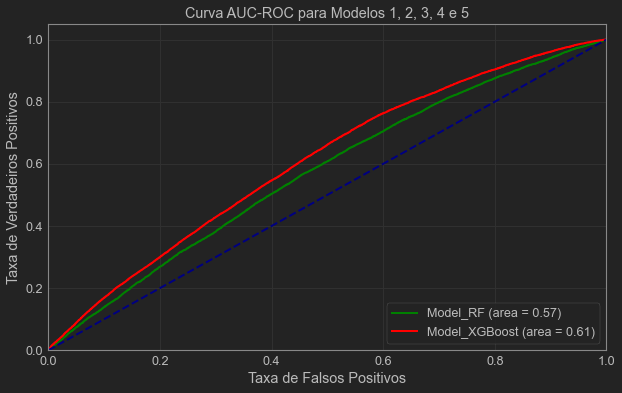

In [114]:
plt.figure(figsize=(15, 10))
# Calcule as probabilidades previstas para cada modelo
probas_3 = clf.predict_proba(X_test)[:, 1]
probas_4 = XGBoost_model.predict_proba(X_test)[:, 1]

# Calcule as curvas ROC para cada modelo

fpr_3, tpr_3, _ = roc_curve(y_test, probas_3)
roc_auc_RF = auc(fpr_3, tpr_3)

fpr_4, tpr_4, _ = roc_curve(y_test, probas_4)
roc_auc_XGB = auc(fpr_4, tpr_4)

# Plote as curvas ROC para cada modelo no mesmo gráfico
plt.figure(figsize=(10, 6))
plt.plot(fpr_3, tpr_3, color='green', lw=2, label='Model_RF (area = %0.2f)' % roc_auc_RF)
plt.plot(fpr_4, tpr_4, color='red', lw=2, label='Model_XGBoost (area = %0.2f)' % roc_auc_XGB)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva AUC-ROC para Modelos 1, 2, 3, 4 e 5')
plt.legend(loc='lower right')
plt.show()

#### Matriz de Confusão

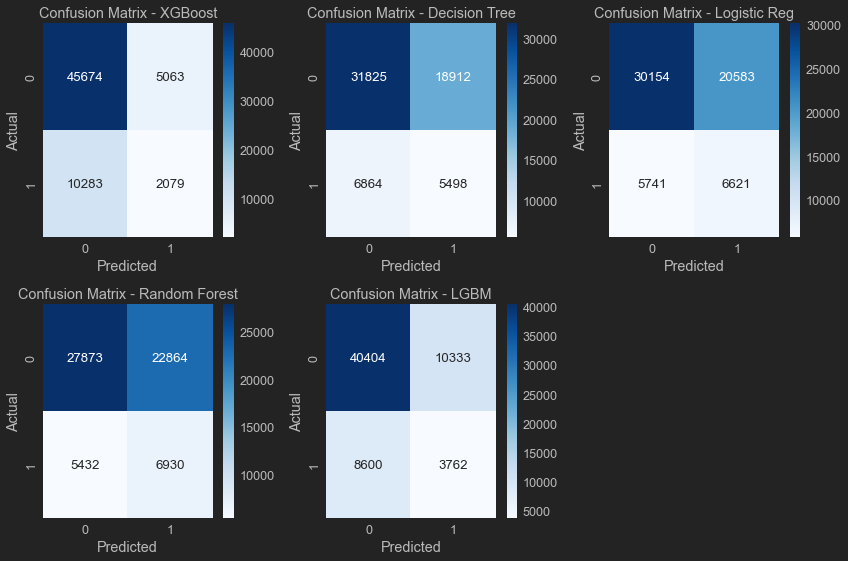

In [364]:
def plot_confusion_matrix_subplot(model, X_test, y_test, title, subplot_position):
    cm = confusion_matrix(y_test, model.predict(X_test))
    plt.subplot(subplot_position)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
plt.figure(figsize=(12, 8))

plot_confusion_matrix_subplot(XGBoost_model, X_test, y_test, "XGBoost", 231)
plot_confusion_matrix_subplot(model_tree, X_test, y_test, "Decision Tree", 232)
plot_confusion_matrix_subplot(model_rl, X_test, y_test, "Logistic Reg", 233)
plot_confusion_matrix_subplot(clf, X_test, y_test, "Random Forest", 234)
plot_confusion_matrix_subplot(model_lgb, X_test, y_test, "LGBM", 235)

plt.tight_layout()
plt.show()

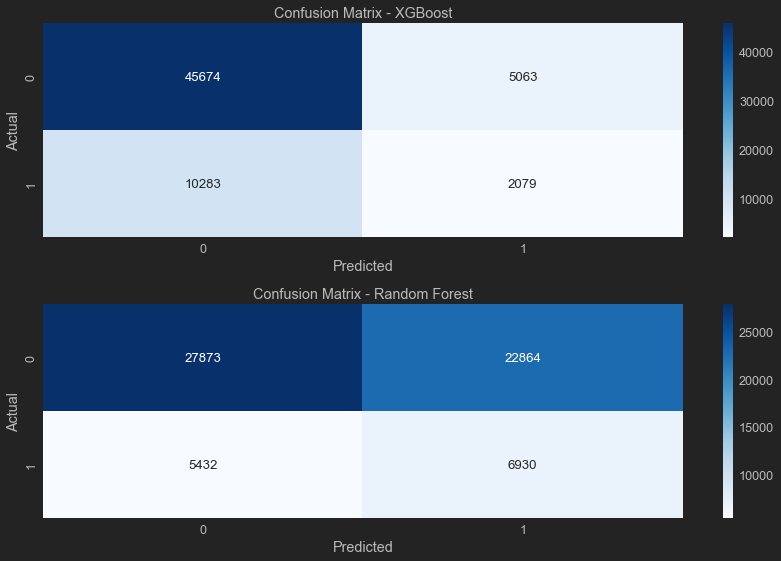

In [115]:
def plot_confusion_matrix_subplot(model, X_test, y_test, title, subplot_position):
    cm = confusion_matrix(y_test, model.predict(X_test))
    plt.subplot(subplot_position)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
plt.figure(figsize=(12, 8))

plot_confusion_matrix_subplot(XGBoost_model, X_test, y_test, "XGBoost", 211)
plot_confusion_matrix_subplot(clf, X_test, y_test, "Random Forest", 212)

plt.tight_layout()
plt.show()

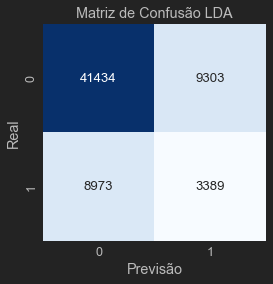

In [365]:
# Matriz de COnfusão do LDA

confusion_lda = confusion_matrix(y_test_lda, y_pred_lda)
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_lda, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusão LDA")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()

#### Explicabilidade dos Modelos

In [432]:
# load JS visualization code to notebook SHAP
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train_over)

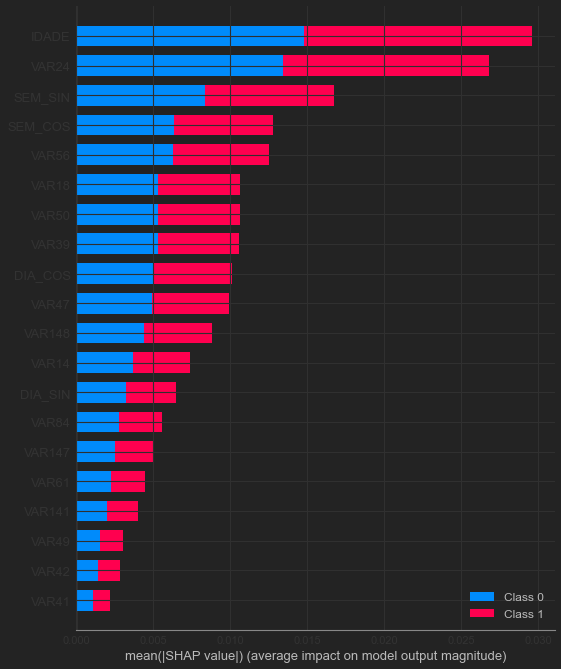

In [433]:
plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values, X_train_over)

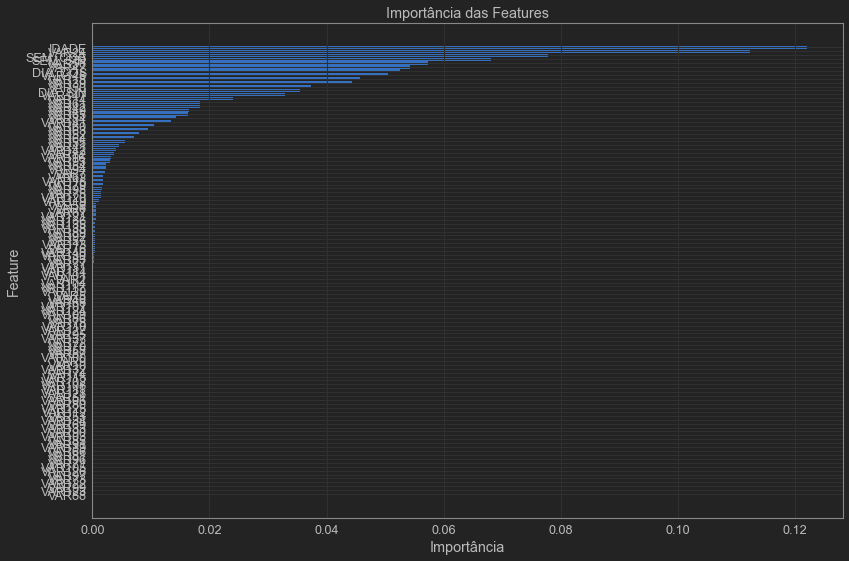

In [434]:
feature_importance = clf.feature_importances_

feature_names = X_train_over.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.title('Importância das Features')

# Ajuste a orientação e o espaçamento dos rótulos
plt.gca().invert_yaxis()  # Inverta o eixo Y para que as features mais importantes apareçam no topo
plt.tick_params(axis='y', labelrotation=0)  # Ajuste a orientação dos rótulos

plt.tight_layout()  # Para evitar que os rótulos se sobreponham
plt.show()

In [369]:
# Classifique o DataFrame 'importance_df' pelas importâncias em ordem decrescente
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Obtenha as 40 primeiras features mais importantes
top_40_features = importance_df.head(40)

# Calcule a porcentagem de importância
total_importance = top_40_features['Importance'].sum()
top_40_features['Porcentagem de Importância'] = (top_40_features['Importance'] / total_importance) * 100

# Exiba o DataFrame com as 40 primeiras features mais importantes e a porcentagem de importância
print(top_40_features[['Feature', 'Importance', 'Porcentagem de Importância']])

     Feature  Importance  Porcentagem de Importância
16   SEM_COS    0.114670                   12.880649
51     VAR56    0.112919                   12.683868
10     VAR50    0.111384                   12.511452
14   SEM_SIN    0.062246                    6.991958
114   VAR147    0.056462                    6.342256
3      VAR24    0.046604                    5.234927
11   DIA_COS    0.039612                    4.449495
20   DIA_SIN    0.039318                    4.416481
23     VAR47    0.034451                    3.869767
7     VAR148    0.027598                    3.100022
37     VAR49    0.026056                    2.926778
55     VAR60    0.022472                    2.524228
0      IDADE    0.019836                    2.228107
58     VAR63    0.012703                    1.426877
47     VAR52    0.012159                    1.365780
39    VAR142    0.012002                    1.348195
72     VAR84    0.010035                    1.127189
2      VAR18    0.009958                    1.

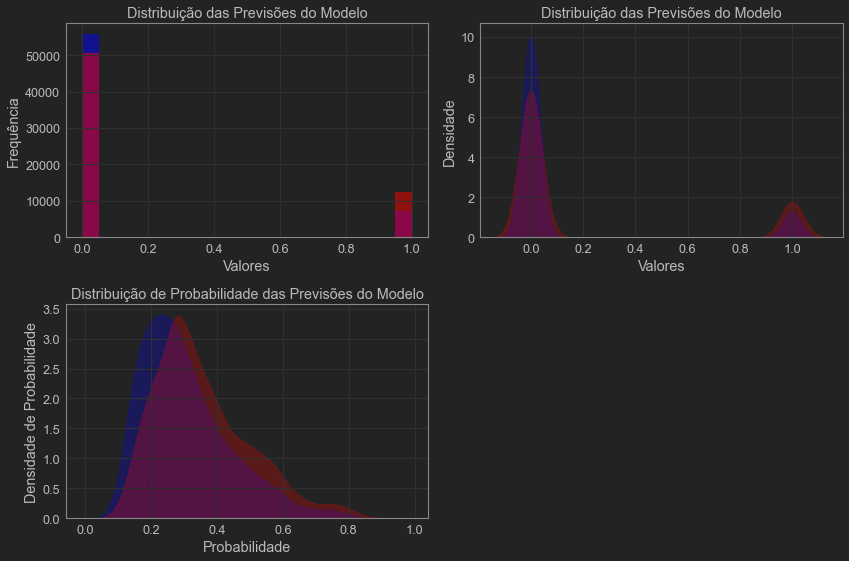

In [372]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(xgb_predic, bins=20, alpha=0.5, color='blue', label='Previsões')
plt.hist(y_test, bins=20, alpha=0.5, color='red', label='Valores Reais')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.title('Distribuição das Previsões do Modelo')

# Grafico de densidade do modelo
plt.subplot(2, 2, 2)
sns.kdeplot(xgb_predic, shade=True, color='blue', label='Previsões')
sns.kdeplot(y_test, shade=True, color='red', label='Valores Reais')
plt.xlabel('Valores')
plt.ylabel('Densidade')
plt.title('Distribuição das Previsões do Modelo')

# Função de Probabilidade do Modelo
y_proba = XGBoost_model.predict_proba(X_test)

plt.subplot(2, 2, 3)
sns.kdeplot(y_proba[y_test == 0, 1], shade=True, color='blue', label='Probabilidade de Classe 1')
sns.kdeplot(y_proba[y_test == 1, 1], shade=True, color='red', label='Probabilidade de Classe 0')
plt.xlabel('Probabilidade')
plt.ylabel('Densidade de Probabilidade')
plt.title('Distribuição de Probabilidade das Previsões do Modelo')

plt.tight_layout()
plt.show()

#### Teste KS - Distribuição de Prob das Classes

In [373]:
y_proba = XGBoost_model.predict_proba(X_test)

proba_class_0 = y_proba[y_test == 0, 1]  
proba_class_1 = y_proba[y_test == 1, 1]  

ks_statistic, ks_p_value = ks_2samp(proba_class_0, proba_class_1)

print(f'Estatística KS: {ks_statistic}')
print(f'Valor p: {ks_p_value}')

alpha = 0.05  
if ks_p_value < alpha:
    print('As distribuições são estatisticamente diferentes.')
else:
    print('Não há evidência estatística de diferença nas distribuições.')

Estatística KS: 0.1659931732616196
Valor p: 7.705146750464608e-240
As distribuições são estatisticamente diferentes.


#### Guardar Modelo

In [374]:
file_name = "model_credit_xgboost.bin"
joblib.dump(XGBoost_model, file_name)

['model_credit_xgboost.bin']

In [116]:
file_name = "model_backtest.bin"
joblib.dump(clf, file_name)

['model_backtest.bin']

## Análise Financeira

Nota: Política de Risco de Crédito Atual = AS-IS.<br>

* Si 'IDADE'<= 28 ===> 'Negado'

Para realizar a análise financeira do seu modelo, suponha que todas as pessoas da base de Teste solicitaram crédito à instituição financeira, na forma de um empréstimo de R$1000,00. Faça o seguinte:

In [375]:
dataframe_treinamento = pd.read_csv('data_base/train.csv')
dataframe_teste = pd.read_csv('data_base/test.csv')

### 01. Calcule qual o tamanho da carteira de crédito aprovado (i.e. quanto de dinheiro a Financeira emprestou) na base de Teste, pela Política AS-IS.

In [377]:
emprestimo = 1000
idade_28_menos = dataframe_teste.query('IDADE<29')
idade_28_mais = dataframe_teste.query('IDADE>=29')
print()
print(f'Política AS-IS')
print(f'---------------------------------------------------')
print(f'A empresa otorga R$.{emprestimo} como empréstimo padrão')
print()
print(f'A nossa carteira conta com {len(idade_28_mais)} clientes')
print()
print(f'A nossa carteira de crédito aprovado é: R$ {len(idade_28_mais)*emprestimo} ')
print(f'---------------------------------------------------')


Política AS-IS
---------------------------------------------------
A empresa otorga R$.1000 como empréstimo padrão

A nossa carteira conta com 48956 clientes

A nossa carteira de crédito aprovado é: R$ 48956000 
---------------------------------------------------


### 02. Calcule qual a dívida total (suponha que os inadimplentes não pagaram nenhuma parcela do empréstimo), pela Política AS-IS.

In [464]:
inadimplente = idade_28_mais.query('TARGET==1')
print()
print(f'Política AS-IS')
print(f'---------------------------------------------------')
print()
print(f'A dívida total é de R$.{len(inadimplente)*emprestimo} ')
print()
print(f'Atualmente existem {len(inadimplente)} clientes inadimplentes')
print()
print(f'---------------------------------------------------')


Política AS-IS
---------------------------------------------------

A dívida total é de R$.40473000 

Atualmente existem 40473 clientes inadimplentes

---------------------------------------------------


#### 3.0. Calcule qual o percentual das pessoas da base de Teste que tiveram a solicitação negada. Agora crie um ponto de corte de seu Score que nega o empréstimo para exatamente o mesmo percentual de pessoas (i.e. o empréstimo será negado para quem tiver o Score igual ou superior ao ponto de corte). Essa é a Política TO-BE.

In [453]:
# ASSUMIREMOS QUE OS CLIENTES SEM IDADE TAMBEM SÃO REJEITADOS, ENTÃO INCLUIREI ISSO NO CALCULO.
client_incognita = dataframe_teste[dataframe_teste['IDADE'].isna()]
totalbasese = len(dataframe_teste) - len(client_incognita)
# CALCULO DE PERCENTUAL DE NEGATIVADOS DE EMPRÉSTIMO
percentual_pessoas_negadas = (len(idade_28_menos)*100)/(totalbasese)
print(f'Política AS-IS')
print(f'---------------------------------------------------')
print("O Percentual de pessoas Negadas de Empréstimo é: {:.2f} % \n".format(percentual_pessoas_negadas))
print(f'---------------------------------------------------')

Política AS-IS
---------------------------------------------------
O Percentual de pessoas Negadas de Empréstimo é: 22.45 % 

---------------------------------------------------


1. Criando um Dataframe para fazer prediçoes

In [442]:
# Fazendo as previsões em formato de probabilidade 
probs1 = clf.predict_proba(X_test)
#Probabilidades da classe 0
class_0_probs1 = probs1[:, 0]
#Probabilidades da classe 1
class_1_probs1 = probs1[:, 1]

# Criando o Datafreme + Scores
df_predicoes = X_test_final[columns] # Crio o datafram
df_predicoes['target'] = copia_df_testes_1['TARGET'] # Adiciono Target
df_predicoes['score'] = class_1_probs1 # Adiciono os Scores

2. Criando pontos de corte:

In [466]:
maior_46 = df_predicoes.query('score>=0.46')
maior_47 = df_predicoes.query('score>=0.475')
maior_48 = df_predicoes.query('score>=0.48')
maior_50 = df_predicoes.query('score>=0.5')
maior_55 = df_predicoes.query('score>=0.55')
maior_56 = df_predicoes.query('score>=0.56')

print(f'Percentual Empréstimo Negado pela Politica TO-BE')
print()
print(f'---------------------------------------------------')
print()
print("Com CORTE 46%: {:.2f} % \n".format(len(maior_46)))
print(f'---------------------------------------------------')
print("Com CORTE 47%: {:.2f} % \n".format(len(maior_47)))
print(f'---------------------------------------------------')
print("Com CORTE 48%: {:.2f} % \n".format(len(maior_48)))
print(f'---------------------------------------------------')
print("Com CORTE 50%: {:.2f} % \n".format(len(maior_50)))
print(f'---------------------------------------------------')
print("Com CORTE 55%: {:.2f} % \n".format(len(maior_55)))
print(f'---------------------------------------------------')
print("Com CORTE 56%: {:.2f} % \n".format(len(maior_56)))
print()
print(f'---------------------------------------------------')

Percentual Empréstimo Negado pela Politica TO-BE

---------------------------------------------------

Com CORTE 46%: 48643.00 % 

---------------------------------------------------
Com CORTE 47%: 42535.00 % 

---------------------------------------------------
Com CORTE 48%: 40199.00 % 

---------------------------------------------------
Com CORTE 50%: 29794.00 % 

---------------------------------------------------
Com CORTE 55%: 3698.00 % 

---------------------------------------------------
Com CORTE 56%: 1295.00 % 


---------------------------------------------------


Com a Política TO-BE, para poder ter o mesmo percentual de 22% aprox de solicitações de Empréstimo Negadas dado pela Política antiga. <br>Devemos fazer o CORTE em 47% aprox  

Nota: Como desafios para próximos passos poderia aprofundar mais no estudo de correlações entre as variáveis. Já que mostraranse de uma  

In [ ]:
Rodar o meu modelo 